# Libraries

In [24]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import TFBertForSequenceClassification, TFBertTokenizer
import torch
from transformers import pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from causalml.inference.meta import LRSRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.inference.meta import BaseXLearner

ModuleNotFoundError: No module named 'causalml'

In [3]:
# Removing row and column limit for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data load

## Data file path

In [4]:
# Download dataset directly to Colab's storage
path = kagglehub.dataset_download("justinpakzad/vestiaire-fashion-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/atharvavyas/.cache/kagglehub/datasets/justinpakzad/vestiaire-fashion-dataset/versions/2


In [5]:
print(os.listdir(path))

['vestiaire.csv']


## Saving the dataframe

In [6]:
df = pd.read_csv(os.path.join(path, 'vestiaire.csv'))

## First 5 rows

In [7]:
df.head()

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,sold,reserved,available,in_stock,should_be_gone,brand_id,brand_name,brand_url,product_material,product_color,price_usd,seller_price,seller_earning,seller_badge,has_cross_border_fees,buyers_fees,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate
0,43247626,Wool mini skirt,Wool mini skirt Miu Miu Grey size S Internatio...,Miu Miu – Pleated mini skirt Size: 36 (S) Wai...,Miu Miu Wool Skirts,Women,Women Clothing,Autumn / Winter,Never worn,34.0,True,False,True,False,False,117,Miu Miu,http://vestiairecollective.com/miu-miu/,Wool,Grey,272.92,223.65,216.94,Common,NaN,NaN,Tourcoing,25775970,vitalii25775970,NaN,Germany,3.0,14.0,0.0,13.0,0.0
1,43247441,Jacket,Jacket Barbara Bui Navy size 42 FR in Cotton,For selling nice women's suit Barbara Bui size...,Barbara Bui Cotton Jackets,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,161,Barbara Bui,http://vestiairecollective.com/barbara-bui/,Cotton,Navy,127.80,106.50,106.50,Common,True,21.30,Tourcoing,13698770,olivia13698770,NaN,Belgium,0.0,0.0,0.0,8.0,0.0
2,43246517,Wool coat,Wool coat Comme Des Garcons White size S Inter...,Magnificent boiled wool coat. I bought it in t...,Comme Des Garcons Wool Coats,Women,Women Clothing,Autumn / Winter,Very good condition,2.0,False,False,True,False,False,391,Comme Des Garcons,http://vestiairecollective.com/comme-des-garcons/,Wool,White,1278.00,1065.00,926.55,Expert,True,213.00,Tourcoing,6042365,cecilia6042365,1-2 days,Spain,58.0,69.0,0.0,62.0,96.0
3,43246507,Mini skirt,Mini skirt MSGM Black size 38 IT in Polyester,MSGM Skirt Black Printed Raw-Edge & Embroidere...,MSGM Polyester Skirts,Women,Women Clothing,All seasons,Very good condition,0.0,False,False,True,False,False,2797,MSGM,http://vestiairecollective.com/msgm/,Polyester,Black,163.90,149.00,126.65,Expert,True,14.90,Brooklyn,13172949,gretchen13172949,1-2 days,United States,63.0,274.0,126346.0,131.0,96.0
4,43246417,Vegan leather trousers,Vegan leather trousers LVIR Black size 36 FR i...,LVIR black grained faux leather trousers size ...,LVIR Vegan leather Trousers,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,11956,LVIR,http://vestiairecollective.com/lvir/,Vegan leather,Black,119.72,99.77,83.55,Common,True,19.95,Crawley,2578605,crunchykat,3-5 days,United Kingdom,19.0,14.0,102821.0,40.0,89.0


## Dataframe info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900514 entries, 0 to 900513
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   product_id                  900514 non-null  int64  
 1   product_type                900514 non-null  object 
 2   product_name                900514 non-null  object 
 3   product_description         900507 non-null  object 
 4   product_keywords            899331 non-null  object 
 5   product_gender_target       900514 non-null  object 
 6   product_category            899331 non-null  object 
 7   product_season              900512 non-null  object 
 8   product_condition           900514 non-null  object 
 9   product_like_count          900514 non-null  float64
 10  sold                        900514 non-null  bool   
 11  reserved                    900514 non-null  bool   
 12  available                   900514 non-null  bool   
 13  in_stock      

# Data cleaning

## Missing data

In [9]:
# Percent of missing values in each column and count of missing values arranged by top 10 most missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage(%)': missing_percentage})
missing_info.sort_values(by='Percentage(%)', ascending=False)


,Missing Values,Percentage(%)
usually_ships_within,154791,17.189183
has_cross_border_fees,13736,1.525351
buyers_fees,13736,1.525351
product_keywords,1183,0.131369
product_category,1183,0.131369
seller_username,39,0.004331
product_description,7,0.000777
product_material,4,0.000444
product_season,2,0.000222
product_color,1,0.000111


Columns this analysis is interested in: **product_description**, **sold**, **price_usd**, **seller_price**. 

Drop missing values of **product_description** 

In [10]:
# Drop all missing values of product_description
df.dropna(subset=['product_description'], inplace=True)

## New column called price_diff

This column will find out how much the price difference is as a percentage of the original price of the product

In [11]:
df['price_diff_percent'] = ((df['price_usd']-df['seller_earning'])/df['price_usd'])*100

In [12]:
df.head()

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,sold,reserved,available,in_stock,should_be_gone,brand_id,brand_name,brand_url,product_material,product_color,price_usd,seller_price,seller_earning,seller_badge,has_cross_border_fees,buyers_fees,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate,price_diff_percent
0,43247626,Wool mini skirt,Wool mini skirt Miu Miu Grey size S Internatio...,Miu Miu – Pleated mini skirt Size: 36 (S) Wai...,Miu Miu Wool Skirts,Women,Women Clothing,Autumn / Winter,Never worn,34.0,True,False,True,False,False,117,Miu Miu,http://vestiairecollective.com/miu-miu/,Wool,Grey,272.92,223.65,216.94,Common,NaN,NaN,Tourcoing,25775970,vitalii25775970,NaN,Germany,3.0,14.0,0.0,13.0,0.0,20.511505
1,43247441,Jacket,Jacket Barbara Bui Navy size 42 FR in Cotton,For selling nice women's suit Barbara Bui size...,Barbara Bui Cotton Jackets,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,161,Barbara Bui,http://vestiairecollective.com/barbara-bui/,Cotton,Navy,127.80,106.50,106.50,Common,True,21.30,Tourcoing,13698770,olivia13698770,NaN,Belgium,0.0,0.0,0.0,8.0,0.0,16.666667
2,43246517,Wool coat,Wool coat Comme Des Garcons White size S Inter...,Magnificent boiled wool coat. I bought it in t...,Comme Des Garcons Wool Coats,Women,Women Clothing,Autumn / Winter,Very good condition,2.0,False,False,True,False,False,391,Comme Des Garcons,http://vestiairecollective.com/comme-des-garcons/,Wool,White,1278.00,1065.00,926.55,Expert,True,213.00,Tourcoing,6042365,cecilia6042365,1-2 days,Spain,58.0,69.0,0.0,62.0,96.0,27.500000
3,43246507,Mini skirt,Mini skirt MSGM Black size 38 IT in Polyester,MSGM Skirt Black Printed Raw-Edge & Embroidere...,MSGM Polyester Skirts,Women,Women Clothing,All seasons,Very good condition,0.0,False,False,True,False,False,2797,MSGM,http://vestiairecollective.com/msgm/,Polyester,Black,163.90,149.00,126.65,Expert,True,14.90,Brooklyn,13172949,gretchen13172949,1-2 days,United States,63.0,274.0,126346.0,131.0,96.0,22.727273
4,43246417,Vegan leather trousers,Vegan leather trousers LVIR Black size 36 FR i...,LVIR black grained faux leather trousers size ...,LVIR Vegan leather Trousers,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,11956,LVIR,http://vestiairecollective.com/lvir/,Vegan leather,Black,119.72,99.77,83.55,Common,True,19.95,Crawley,2578605,crunchykat,3-5 days,United Kingdom,19.0,14.0,102821.0,40.0,89.0,30.212162


## Descriptive statistics for numerical columns

In [13]:
df.describe()

,product_id,product_like_count,brand_id,price_usd,seller_price,seller_earning,buyers_fees,seller_id,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate,price_diff_percent
count,9.005070e+05,900507.000000,900507.000000,900507.000000,900507.000000,900507.000000,886771.000000,9.005070e+05,900507.000000,900507.000000,9.005070e+05,9.005070e+05,900507.000000,900507.000000
mean,3.810022e+07,6.298300,2437.270803,386.864061,331.640751,290.437698,55.486339,1.382232e+07,664.959983,1497.669615,5.623196e+04,9.904691e+03,72.461618,29.868420
std,7.749142e+06,12.920106,3702.867265,1859.566252,1591.478879,1498.163329,290.261103,7.535594e+06,3552.758248,5460.187171,1.438161e+05,3.557500e+05,34.428758,10.918541
min,1.113630e+05,0.000000,2.000000,6.130000,5.110000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,-180.000000,0.000000
25%,3.811600e+07,1.000000,66.000000,83.070000,71.360000,58.580000,11.720000,7.977389e+06,6.000000,10.000000,0.000000e+00,1.700000e+01,68.000000,26.666139
50%,4.174208e+07,3.000000,341.000000,168.700000,143.780000,125.370000,23.970000,1.438324e+07,34.000000,52.000000,0.000000e+00,7.300000e+01,88.000000,27.526370
75%,4.267775e+07,7.000000,3266.000000,350.000000,298.200000,261.900000,50.480000,1.946237e+07,178.000000,373.000000,2.539400e+04,2.900000e+02,95.000000,32.137268
max,4.324884e+07,3154.000000,18237.000000,632610.000000,527175.000000,509229.750000,105435.000000,2.608177e+07,79738.000000,39628.000000,1.064736e+06,1.417912e+07,100.000000,100.000000


# EDA

## Checking the product description column for possible text analysis

In [14]:
def show_full_description(df):
    with pd.option_context('display.max_colwidth', None):
        print(df[['product_description']].head(15))

In [15]:
show_full_description(df)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          product_description
0                                                                                                                                                                                                                                                                                                                                                                                         

## Class profile of product target gender

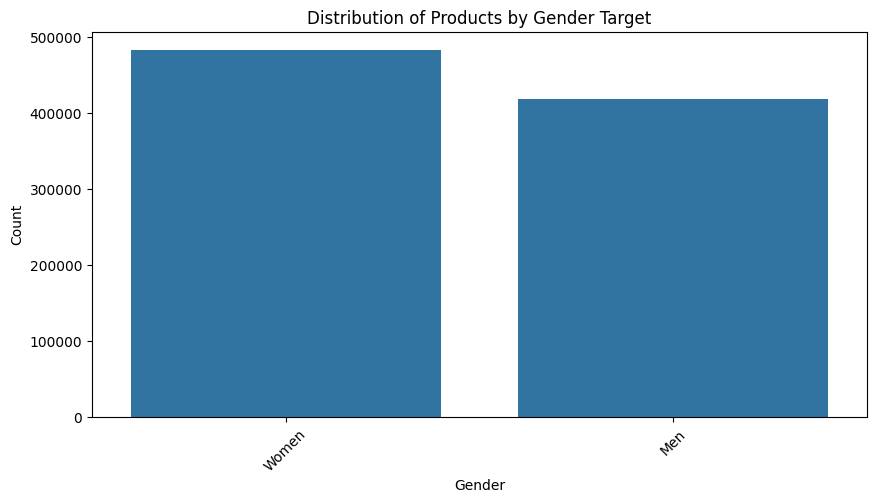

In [16]:
# Class imbalance visualised with plot for difference between male and female in gender column
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='product_gender_target')
plt.title('Distribution of Products by Gender Target')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Slightly imbalanced class, this is okay.

# Causal ML

### Hyopthesis :
Is overselling a product motivated by higher seller earnings?

In [19]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/atharvavyas/nltk_data...


True

In [20]:
# Initialize analyzer
sia = SentimentIntensityAnalyzer()

In [21]:
# Enhance VADER with luxury/fashion-specific positive words
luxury_words = {
    'magnificent': 4.0, 'elegant': 3.5, 'beautiful': 3.0, 
    'perfect': 3.0, 'excellent': 3.0, 'amazing': 3.0
}
sia.lexicon.update(luxury_words)

# Extract sentiment features
df['sentiment_pos'] = df['product_description'].apply(lambda x: sia.polarity_scores(x)['pos'])
df['sentiment_compound'] = df['product_description'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['luxury_word_count'] = df['product_description'].apply(
    lambda x: sum(1 for word in luxury_words if word.lower() in x.lower())
)



Y = df['price_diff_percent']
T = df['sentiment_compound']
X = df[['product_category', 'product_condition', 'brand_id', 'seller_badge']]
X = pd.get_dummies(X, drop_first=True)

est = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestRegressor(),
    n_estimators=1000
)
est.fit(Y, T, X=X)
effects = est.effect(X)

ModuleNotFoundError: No module named 'econml'